In [ ]:
# %pip install selenium
# %pip install pygetwindow
# %pip install pillow

In [1]:
import os
import time
import random
from PIL import ImageGrab
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from pygetwindow import getWindowsWithTitle as gw
import pyautogui
from itertools import combinations

In [2]:
# === Config ===
view_delay = 0.25
image_count = 0
dataset_base = "dataset-H"

buttons = {
    "front_left_door": "Front Left Door",
    "front_right_door": "Front Right Door",
    "rear_left_door": "Rear Left Door",
    "rear_right_door": "Rear Right Door",
    "hood": "Hood"
}

In [3]:
# === Setup Chrome Driver ===
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(options=options)
driver.get("http://103.233.100.26:8080/")

📍 Canvas HTML location: {'x': 192, 'y': 101}
📐 HTML-reported size: {'height': 810, 'width': 1536}
🧩 CSS-rendered size: 1536.0 x 810.391
🖥️  Screen box: (184, 93, 1720, 903)


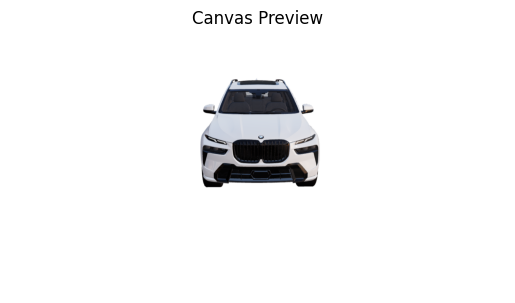

(184, 93, 1720, 903)

In [9]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from PIL import Image
import io
import matplotlib.pyplot as plt

def get_canvas_box(driver, timeout=10):
    try:
        # Wait until the canvas element is present and visible
        canvas = WebDriverWait(driver, timeout).until(
            EC.visibility_of_element_located((By.TAG_NAME, "canvas"))
        )

        # Scroll the element into view
        location = canvas.location_once_scrolled_into_view
        size = canvas.size

        # Get CSS-rendered size (can differ from raw HTML size)
        css_width = float(canvas.value_of_css_property("width").replace('px', ''))
        css_height = float(canvas.value_of_css_property("height").replace('px', ''))

        # Get browser window screen position
        win_pos = driver.get_window_position()

        # Calculate absolute screen position of the canvas
        screen_left = win_pos['x'] + int(location['x'])
        screen_top = win_pos['y'] + int(location['y'])
        screen_right = screen_left + int(css_width)
        screen_bottom = screen_top + int(css_height)

        print(f"📍 Canvas HTML location: {location}")
        print(f"📐 HTML-reported size: {size}")
        print(f"🧩 CSS-rendered size: {css_width} x {css_height}")
        print(f"🖥️  Screen box: ({screen_left}, {screen_top}, {screen_right}, {screen_bottom})")

        # Preview canvas (no saving)
        image_data = canvas.screenshot_as_png
        image = Image.open(io.BytesIO(image_data))
        plt.imshow(image)
        plt.axis('off')
        plt.title("Canvas Preview")
        plt.show()

        return (screen_left, screen_top, screen_right, screen_bottom)

    except Exception as e:
        print(f"❌ Failed to get canvas box: {e}")
        return None

# Usage
get_canvas_box(driver)


In [ ]:
# === Helper Functions ===

def toggle(button_text):
    try:
        btn = driver.find_element(By.XPATH, f"//button[contains(text(), '{button_text}')]")
        btn.click()
        time.sleep(view_delay)
        return True
    except Exception as e:
        print(f"Toggle Failed {button_text}: {e}")
        return False

def random_rotate_model():
    screen_width, screen_height = pyautogui.size()
    start_x = screen_width // 6  # Slightly to the left of center
    start_y = screen_height // 2

    pyautogui.moveTo(start_x, start_y)

    dx = random.randint(200, 210) #* random.choice([-1, 1])
    dy = random.randint(0, 0) #* random.choice([-1, 1])
    pyautogui.dragRel(dx, dy, duration=0.4, button='left')  # Hold left click to rotate

def random_zoom():
    zoom_amount = random.randint(1, 5) * random.choice([-1, 1])
    pyautogui.scroll(zoom_amount * 100)  # Zoom in or out by mouse scroll

def capture_image(folder_name, label_dict):
    global image_count
    time.sleep(view_delay)

    try:
        canvas = driver.find_element(By.TAG_NAME, "canvas")

        save_dir = os.path.join(dataset_base, folder_name)
        os.makedirs(save_dir, exist_ok=True)

        label_str = "-".join([f"{k}_{v}" for k, v in label_dict.items()])
        filename = f"{label_str}_{image_count:04d}.png"
        filepath = os.path.join(save_dir, filename)

        image_data = canvas.screenshot_as_png
        image = Image.open(io.BytesIO(image_data))
        image.save(filepath)

        print(f"✅ Saved: {filepath}")
        image_count += 1

    except Exception as e:
        print(f"❌ Failed to capture or save image: {e}")

def get_label_state(active_key=None):
    label = {key: "closed" for key in buttons.keys()}
    if active_key:
        label[active_key] = "opened"
    return label

while True:
    angle_input = input("\n🎯 Enter angle index (or type 'quit' to stop): ").strip().lower()
    if angle_input == "quit":
        print("\n🛑 Exiting capture loop.")
        break

    if not angle_input.isdigit():
        print("⚠️ Please enter a valid number for angle or 'quit' to exit.")
        continue

    angle_tag = f"angle-{angle_input}"
    print(f"\n🔄 Starting capture cycle for {angle_tag}...")

    try:
        time.sleep(1.5)
        # random_rotate_model()
        # random_zoom()

        # === 1. All doors closed
        print("🧊 Capturing: all_closed")
        label = get_label_state()
        capture_image(angle_tag + "/all_closed", label)

        # === 2. Open each combination of doors
        button_keys = list(buttons.keys())
        for num_doors in range(1, len(button_keys) + 1):
            for combo_keys in combinations(button_keys, num_doors):
                print(f"\n🔓 Opening: {[buttons[k] for k in combo_keys]}")
                for key in combo_keys:
                    toggle(buttons[key])

                label = {key: "opened" if key in combo_keys else "closed" for key in buttons.keys()}
                folder_name = f"{angle_tag}/{num_doors}door_open"
                capture_image(folder_name, label)

                print(f"🔒 Closing: {[buttons[k] for k in combo_keys]}")
                for key in combo_keys:
                    toggle(buttons[key])

        print(f"\n✅ Finished capturing for {angle_tag}.")

    except KeyboardInterrupt:
        print("\n🛑 Stopped by user manually.")
        # driver.quit()
        break


🔄 Starting capture cycle for angle-0...
🧊 Capturing: all_closed
✅ Saved: dataset-G\angle-0/all_closed\front_left_door-closed_front_right_door-closed_rear_left_door-closed_rear_right_door-closed_hood-closed_0079.png

🔓 Opening: ['Front Left Door']
✅ Saved: dataset-G\angle-0/1door_open\front_left_door-opened_front_right_door-closed_rear_left_door-closed_rear_right_door-closed_hood-closed_0080.png
🔒 Closing: ['Front Left Door']

🔓 Opening: ['Front Right Door']
✅ Saved: dataset-G\angle-0/1door_open\front_left_door-closed_front_right_door-opened_rear_left_door-closed_rear_right_door-closed_hood-closed_0081.png
🔒 Closing: ['Front Right Door']

🔓 Opening: ['Rear Left Door']
✅ Saved: dataset-G\angle-0/1door_open\front_left_door-closed_front_right_door-closed_rear_left_door-opened_rear_right_door-closed_hood-closed_0082.png
🔒 Closing: ['Rear Left Door']

🔓 Opening: ['Rear Right Door']
✅ Saved: dataset-G\angle-0/1door_open\front_left_door-closed_front_right_door-closed_rear_left_door-closed_rea